In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

/home/mri/.local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/mri/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/mri/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in ver

In [2]:
import grad_cam
from meanpertrub import MeanPertrub

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = '/home/mri/Druzhinina/project/checkpoints/'
isTrain = True

In [3]:
X = np.load('/home/mri/datasets/adni/tensors_cut.npz')
y = np.load('/home/mri/datasets/adni/labels.npy')

In [4]:
X = X.f.arr_0

In [5]:
print(X.shape, y.shape)

(517, 1, 180, 180, 180) (517,)


In [5]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
#         sample = {'img': self.X[idx], 'landmarks': self.y[idx]}
#         if self.transform:
#                    sample = self.transform(sample)
        return self.X[idx], self.y[idx]

In [8]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=4*c*5*5*5, out_features=2),
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [7]:
## Hidden layers 1, 2 and 3
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)), # Convolutional layer
    nn.BatchNorm3d(c_out), # Batch Normalization layer
    nn.ReLU(), # Activational layer
    nn.MaxPool3d(3) # Pooling layer
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.hidden4 = hidden(4*c, 4*c)
        self.linear = nn.Linear(128, 2)#16000
#         self.linear = nn.Linear(128*5*5*5, 2)#16000
        self.flatten = nn.Flatten()

    def forward(self, x):
#         print(x.shape)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
#         print(x.shape)
        x = self.flatten(x)
        x = self.linear(x)
        
        x = F.log_softmax(x, dim=1)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNet(c)

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [0]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [0] GPUs!


In [15]:
dataset = MriData(X, y, transform=None)

In [16]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

## Meaningful Perturbations

In [12]:
X[:2].shape

(2, 1, 180, 180, 180)

In [30]:
torch.cuda.empty_cache()

In [17]:
isTrain = True

In [11]:
if isTrain:
    with torch.no_grad():
        loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
        net = model.to(device)
        net.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_adam-4_sch'), map_location=device))#change path
        net = net.float()
        net.eval()
        for param in net.parameters():
            param.requires_grad = False
        pred = np.concatenate(get_prediction(net, loader, device), axis=0)
        pertrub = MeanPertrub(device)
    masks_pertrub = pertrub.get_masks(X[:2], pred[:2], net)
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub'), masks_pertrub)
else:
    masks_pertrub = np.load(os.path.join(CHECKPOINTS_DIR,'masks_pertrub.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/mri/Druzhinina/project/checkpoints/masks_pertrub.npy'

In [ ]:
!nvidia-smi

In [72]:
man_idx = np.arange(y[:len()].shape[0])[y == 1]
woman_idx = np.arange(y.shape[0])[y == 0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = man_mean_mask + woman_mean_mask

TypeError: len() takes exactly one argument (0 given)

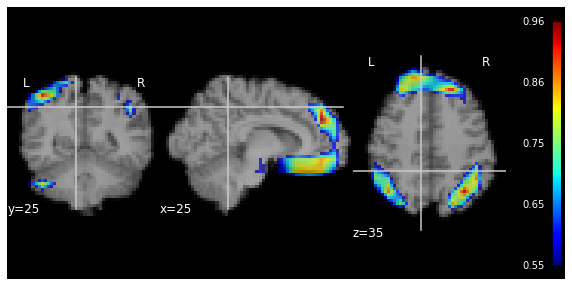

In [5]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')

In [14]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# EPOCHS = 20
# m = 0
# cross_mask =[]
# for Mask in [man_mean_mask, woman_mean_mask, mean_mask]:
#     torch.manual_seed(82)
#     torch.cuda.manual_seed(82)
#     np.random.seed(82)
#     print('Doing {} mask'.format(m))
#     m += 1
#     cross_vall_acc_list = []
#     j = 0
#     for train_index, test_index in skf.split(X, y,):
#         print('Doing {} split'.format(j))
#         j += 1
    
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         train_dataset = MriData(X_train, y_train)
#         val_dataset = MriData(X_test * Mask, y_test)
#         train_loader = torch_data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
#         val_loader = torch_data.DataLoader(val_dataset, batch_size=28, shuffle=False) 
        
#         model = mri_model.MriNet(C).to(device)
#         criterion = nn.NLLLoss( )
#         optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#         scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    
#         train(EPOCHS, model, criterion, optimizer, train_loader, val_loader,device,scheduler=scheduler, save=False, verbose=False) 
#         cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
#     cross_mask.append(cross_vall_acc_list)
# cv_acc = np.array(cross_mask)
# np.save(os.path.join(CHECKPOINTS_DIR, 'cv_masks'), cv_acc)

In [9]:
# print('Mean cross-validation accuracy for man mask (10-folds):', np.mean(cv_acc[0]))
# print('Std cross-validation accuracy for man mask (10-folds):', np.std(cv_acc[0], ddof=1))
# print()
# print('Mean cross-validation accuracy for woman mask (10-folds):', np.mean(cv_acc[1]))
# print('Std cross-validation accuracy for woman mask (10-folds):', np.std(cv_acc[1], ddof=1))
# print()
# print('Mean cross-validation accuracy for conj mask (10-folds):', np.mean(cv_acc[2]))
# print('Std cross-validation accuracy for conj mask (10-folds):', np.std(cv_acc[2], ddof=1))

Mean cross-validation accuracy for man mask (10-folds): 58.55131874084473
Std cross-validation accuracy for man mask (10-folds): 17.855139440353028

Mean cross-validation accuracy for woman mask (10-folds): 59.21171226501465
Std cross-validation accuracy for woman mask (10-folds): 7.450806550883195

Mean cross-validation accuracy for conj mask (10-folds): 82.4814998626709
Std cross-validation accuracy for conj mask (10-folds): 12.269369407659404


## Grad CAM

In [18]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_MriNetGrad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam'), masks_grad)
else:
    masks_grad = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam.npy'))

100%|██████████| 517/517 [02:02<00:00,  4.22it/s]


In [34]:
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))


In [19]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()

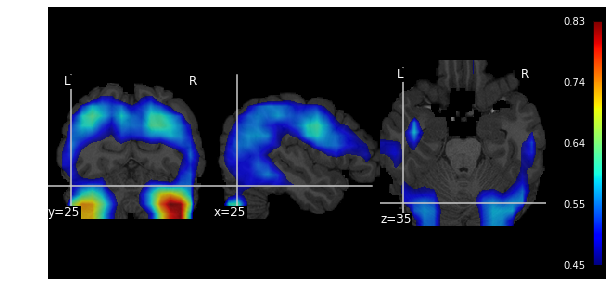

In [55]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad[y==0].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[3]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.45)
plt.show()
fig.savefig("grad_cam.png", bbox_inches='tight')

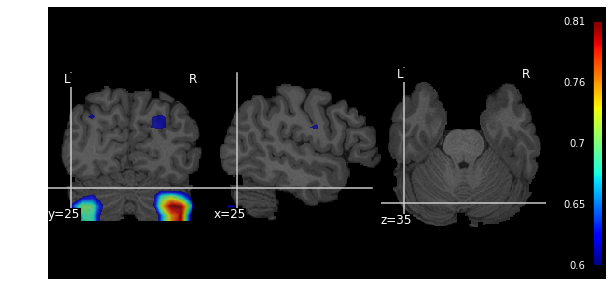

In [90]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.6)
plt.show()
fig.savefig("grad_cam.png", bbox_inches='tight')

## Guided Back-propagation

In [29]:
if isTrain:
    masks_gb = grad_cam.get_masks(model.module, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb'), masks_gb)
else:
    masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))

100%|██████████| 517/517 [09:01<00:00,  1.05s/it]


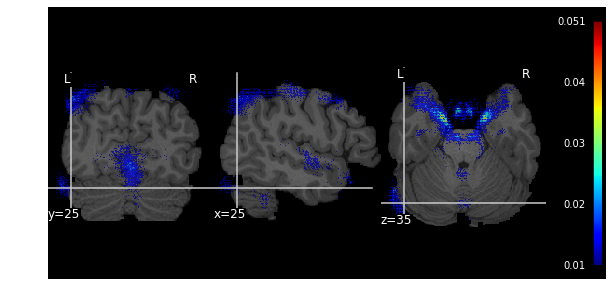

In [89]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb[y==1].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.01)
plt.show()
fig.savefig("guided backpropagation.png", bbox_inches='tight')

## DICE

In [70]:
def dice(x, y):
    overlap = x == y
    return 2 * overlap.sum() / (x.size + y.size)

In [91]:
# p_g = dice(mean_mask > 0.65, masks_grad.mean(axis=0) > 0.65)
# print('Dice between Meaningful Perturbations mask and Grad Cam mask', p_g)

In [92]:
# p_b = dice(mean_mask > 0.65, masks_gb.mean(axis=0) > 0.04)
# print('Dice between Meaningful Perturbations mask and Guided Back-propagation', p_b)

In [78]:
gm = masks_grad.mean(axis=0)
gbm = masks_gb.mean(axis=0)

In [88]:
g_b = dice(gm > 0.6, gbm > 0.01)
print('Dice between Grad Cam mask and Guided Back-propagation', g_b)

Dice between Grad Cam mask and Guided Back-propagation 0.9410797325102881
